# Wage prediction

현대축구에서는 우수한 측면수비수를 보유한 팀이 세계를 지배한다.  
누가 과연 좋은 측면수비수일지 예측해보자.  
물론 평가기준은... **돈**이다!!   
**(프로는 돈으로 말한다)**

- Target : `Wage`
- Metric : `mse`  (mse나 rmse나 결국 단위의 차이...)
- Player : only.. 측면수비.. `RB`, `RWB`, `LB`, `LWB`
- Stat : except GK stats

참고

- https://lovit.github.io/visualization/2019/11/22/seaborn_tutorial/
- https://seaborn.pydata.org/examples/index.html
- https://seaborn.pydata.org/examples/distplot_options.html
- https://datascienceschool.net/view-notebook/4c2d5ff1caab4b21a708cc662137bc65/

# 모듈

In [1]:
import os
import sys
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
from time import sleep

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#그래프 폰트 전역 설정
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'calibri'
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelsize']   = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['xtick.labelsize'] = 16


import sklearn

# 데이터 불러오기

In [2]:
# 디렉토리 내 파일 확인
os.listdir()

['.ipynb_checkpoints',
 'EDA.ipynb',
 'fifa19.csv',
 'Kmeans 연습.ipynb',
 'PCA 실전.ipynb',
 'PCA 연습.ipynb',
 'players_20.csv',
 'Untitled.ipynb',
 '나만의 EDA_FIFA.ipynb',
 '코사인 유사도 연습.ipynb',
 '피파 Linear Regression.ipynb',
 '피파 머신러닝 연습(EDA).ipynb',
 '피파 머신러닝 흐름잡기.ipynb',
 '피파 머신러닝.zip']

In [161]:
# 실습을 위해 미리 데이터 보고 내가 임의로 분리

fifa = pd.read_csv('fifa19.csv', index_col=0)
fifa = fifa[fifa.Position!='GK'].reset_index(drop=True)

position = ['LB','LWB','RB','RWB']
fifa = fifa.query("Position in @position").reset_index(drop=True)

fifa =  fifa.loc[:,['Wage','Value','Name', 'Age','Nationality',
       'Overall', 'Club','Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight',
       'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']]

# 키/몸무게 전처리 (숫자로 변환)
fifa[['feet','inch']] = fifa['Height'].str.split('[^\d]', expand=True).astype('int')
fifa['Height'] = 30.48 * fifa['feet'] + 2.54 * fifa['inch']
fifa['Weight'] = fifa.Weight.str.replace('[^\d]','').astype('float')*0.4536

fifa.head()

Wage   Value         Name  Age Nationality  Overall               Club  \
0  €285K    €43M      Marcelo   30      Brazil       88        Real Madrid   
1  €250K    €38M   Jordi Alba   29       Spain       87       FC Barcelona   
2  €160K  €36.5M  Alex Sandro   27      Brazil       86           Juventus   
3  €175K    €35M  Azpilicueta   28       Spain       86            Chelsea   
4  €110K    €38M     D. Alaba   26     Austria       85  FC Bayern München   

  Preferred Foot  International Reputation  Weak Foot  ...  Interceptions  \
0           Left                     $4.00      $4.00  ...         $85.00   
1           Left                     $3.00      $3.00  ...         $84.00   
2           Left                     $3.00      $3.00  ...         $82.00   
3          Right                     $3.00      $3.00  ...         $89.00   
4           Left                     $4.00      $4.00  ...         $84.00   

  Positioning Vision Penalties Composure  Marking StandingTackle  \
0      $85.00 $82.00    $59.00    $86.00   $71.00         $85.00   
1      $79.00 $70.00    $59.00    $79.00   $72.00         $84.00   
2      $70.00 $70.00    $60.00    $82.00   $81.00         $84.00   
3      $62.00 $74.00    $66.00    $78.00   $88.00         $90.00   
4      $76.00 $77.00    $80.00    $79.00   $80.00         $82.00   

  SlidingTackle feet  inch  
0        $86.00    5     9  
1        $85.00    5     7  
2        $84.00    5    11  
3        $86.00    5    10  
4        $80.00    5    11  

[5 rows x 52 columns]

# X_train, X_test / y_train, y_test 분리

In [190]:
from sklearn.model_selection import train_test_split

# 능력치 순 상위 n명만 분리
n = 1000

X   = fifa.loc[:n,['Name', 'Age','Nationality','Overall', 'Club',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From',
       'Height', 'Weight',
       'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']]

# Wage 전처리 (숫자로 변환)
y = fifa.loc[:n,['Wage']]
y.Wage  = y.Wage.str.replace('[^.\d]','').astype('float')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,shuffle=True)

# EDA

In [186]:
print( '<df.shape>')
print( '[X_train]:{}, [y_train]:{}'.format(X_train.shape, y_train.shape) )
print( '[X_test] :{}, [y_test] :{}'.format(X_test.shape, y_test.shape) )

<df.shape>
[X_train]:(1400, 47), [y_train]:(1400, 1)
[X_test] :(601, 47), [y_test] :(601, 1)


In [170]:
df = X_train
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 432 to 37
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      700 non-null    object 
 1   Age                       700 non-null    int64  
 2   Nationality               700 non-null    object 
 3   Overall                   700 non-null    int64  
 4   Club                      688 non-null    object 
 5   Preferred Foot            700 non-null    object 
 6   International Reputation  700 non-null    float64
 7   Weak Foot                 700 non-null    float64
 8   Skill Moves               700 non-null    float64
 9   Work Rate                 700 non-null    object 
 10  Body Type                 700 non-null    object 
 11  Real Face                 700 non-null    object 
 12  Position                  700 non-null    object 
 13  Jersey Number             700 non-null    float64
 14  Joined   

## 결측치 확인

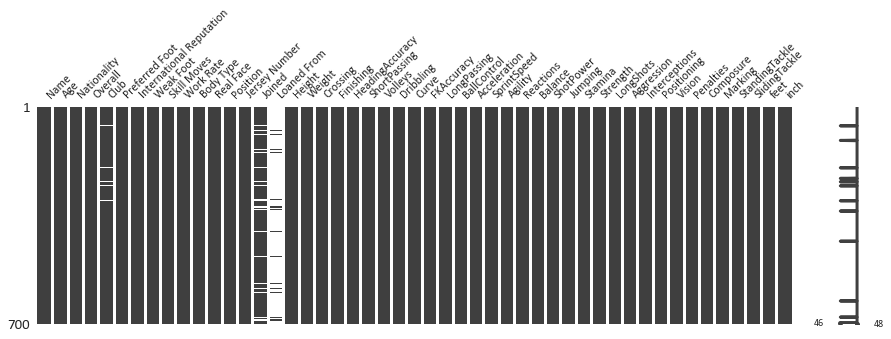

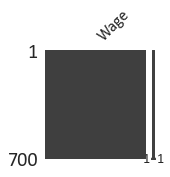

In [159]:
#결측치 확인
msno.matrix(X_train, figsize=(15,4), fontsize=12),
msno.matrix(y_train, figsize=(2,2)) ;

In [10]:
def missing(df):
    missing = df.isnull().sum().reset_index()         
    missing.columns = ['column', 'num']                       
    missing['ratio'] = missing['num'] / len(df)
    missing = missing.sort_values(by='num', ascending=False)
    missing = missing.loc[missing['ratio'] != 0 ]

    missing.plot(kind='bar', x='column', y='ratio', figsize=(12,4))
    plt.title('Missing Ratio', fontsize=20)
    plt.xticks(fontsize=18, rotation=30, weight='bold')
    plt.ylabel('ratio',fontsize=20, rotation=90)
    plt.ylim(0,1)
    
    return missing
    

column  num     ratio
15  Loaned From  664  0.948571
14       Joined   48  0.068571
4          Club   12  0.017143

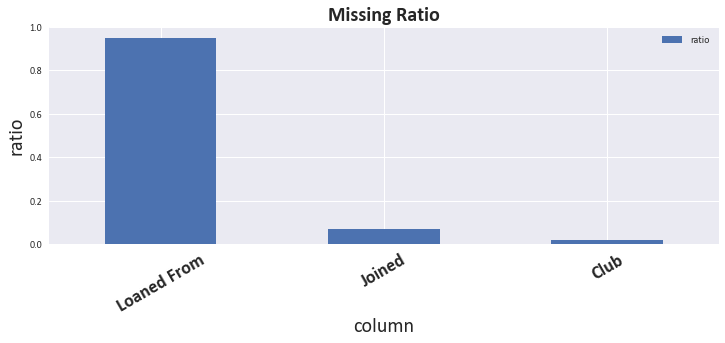

In [11]:
df = X_train
missing(df)

## y 분포 확인

In [171]:
y_train.head()

Wage
432 $17.00
671  $8.00
641  $5.00
805  $7.00
920  $9.00

Text(0.5, 0, 'log(Wage)')

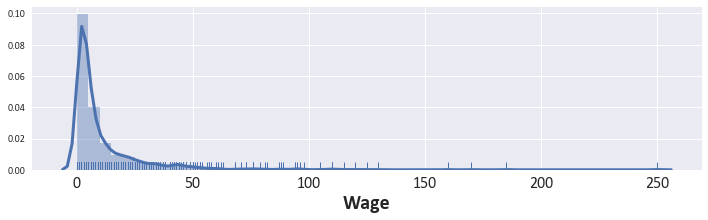

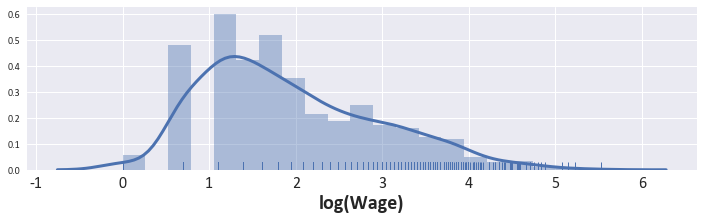

In [187]:
df = y_train
plt.figure(figsize=(12,3))
sns.distplot(df, kde=True, rug=True)
plt.xlabel('Wage',fontsize=20, weight='bold', rotation=0)


df = np.log1p(y_train)
plt.figure(figsize=(12,3))
sns.distplot(df, kde=True, rug=True)
plt.xlabel('log(Wage)',fontsize=20, weight='bold', rotation=0)

# EDA 함수 정의하기

**numpy, pandas, matplotlib, seaborn** 을 import 해야함

- `eda_catecorical` : 범주형변수(+@ 서열변수) 분포확인, 결측치확인
- `cat_N_y` : 범주형변수와 y의 관계


- `eda_continuous` : 연속형변수 분포확인, 결측치확인
- `con_N_y` : 연속형변수와 y의 관계

In [14]:
def eda_categorical(feature) :

    a = feature.count()
    b = feature.isnull().sum()
    miss = b/(a+b)
    miss = round(miss,4)
    print('\n━━━━━━━━━━━━━━━━━━━━━━━ 【{}】 ━━━━━━━━━━━━━━━━━━━━━━━'.format(feature.name))
    print('Count:{0} | Null:{1} | Missing Ratio:{2}\n'.format(a,b,miss))
    
    df = pd.DataFrame(feature.value_counts()).reset_index()
    col_a = df.columns[1]
    col_b = 'num'
    
    df.columns = [col_a, col_b]
    df = df.sort_values(by=col_a)
    df = df.reset_index().iloc[:,1:3]
    
    df['percent'] = round( (df['num'] * 100) / df['num'].sum(), 2)
    df=df.sort_values(by='num', ascending=False)
    
    print(df)
   
    if len(feature.unique()) < 51:
        
        plt.figure(figsize=(15,2))
        countplot = sns.countplot(feature)
        plt.xlabel(feature.name,fontsize=20, rotation=0 , weight='normal')
        plt.xticks(weight='bold', rotation=60)
        plt.show()

In [15]:
def cat_N_y(x,y):
    if len(x.unique()) < 51:
        
        plt.figure(figsize=(15,4))
        plt.xticks(weight='bold', rotation=60)

        sns.boxplot(x=x, y=y, color='#f5f5f5', linewidth=1.5)
        sns.stripplot(x=x, y=y, jitter=True, alpha=0.5, size=5)
        plt.show()

In [17]:
def eda_continuous(x):
    
    a = x.count()
    b = x.isnull().sum()
    miss = b/(a+b)
    miss = round(miss,4)
    
    c = '[{}]'.format(x.name)
    d = 'Count:{0} | Null:{1} | Missing Ratio:{2}'.format(a,b,miss)   

    plt.figure(figsize=(16,0.8))
    plt.text(0.5,0.6, c,fontsize=20, weight='bold',ha='center')
    plt.text(0.5,0.1, d,fontsize=18, weight='normal',ha='center')
    plt.xticks(fontsize=0), plt.yticks(fontsize=0)
    plt.grid(False)
    plt.show()
    
    plt.figure(figsize=(7,1))
    sns.distplot(x, kde=True, rug=True,bins=20, kde_kws=dict(linewidth=4))
    plt.xlabel(x.name, fontsize=20, rotation=0, weight='normal')
    plt.show()

In [22]:
def con_N_y(x,y):
    
    # Set up the matplotlib figure
    f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=False)
    sns.despine(left=True)
    
    sns.regplot(x,y,lowess=True,
               scatter_kws={'s':25, 'alpha':0.3, 'color':'#003458'},
               line_kws={"linewidth": 4, "color": "#ED5A66", "alpha":0.5},
               ax=axes[0])
    sns.regplot(x,y,lowess=False,
               scatter_kws={'s':25, 'alpha':0.01},
               line_kws={"linewidth": 4, "color": "#A0203A", "alpha":0.5},
               ax=axes[0])   
   
    plt.xlabel(x.name,fontsize=20, rotation=0 , weight='normal')
    plt.ylabel(y.name,fontsize=20, rotation=90, weight='normal')
    ###########################################################################
    sns.residplot(x, y,lowess=True, color='#003458',
                 line_kws={"linewidth": 4, "color": "#ED5A66",'alpha':0.5},
                 scatter_kws={'s':25, 'alpha':0.3},
                 ax=axes[1])
    plt.xlabel(x.name,fontsize=20, rotation=0 , weight='normal')
    plt.ylabel('Residual',fontsize=20, rotation=90, weight='normal')

In [167]:
# catergorical과 continuous를 분리하기 위해 변수 확인
X_train.columns

Index(['Name', 'Age', 'Nationality', 'Overall', 'Club', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Joined',
       'Loaned From', 'Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle'],
      dtype='object')

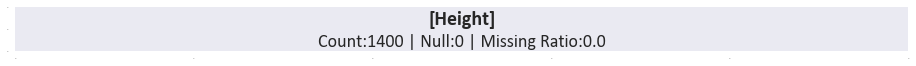

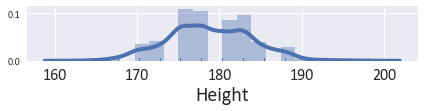

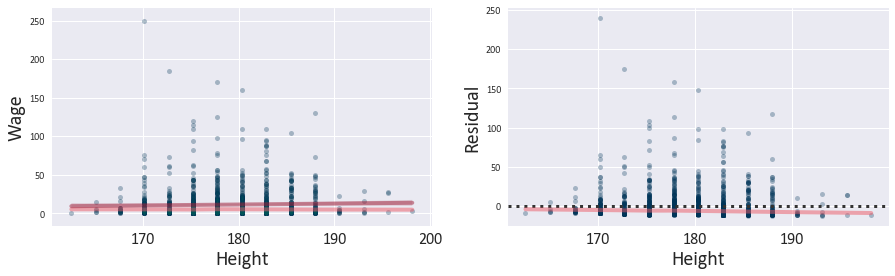

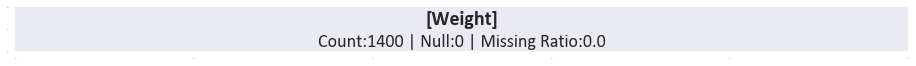

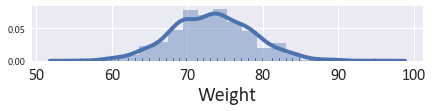

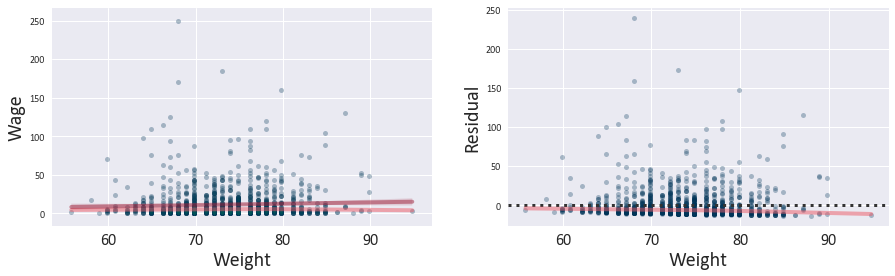

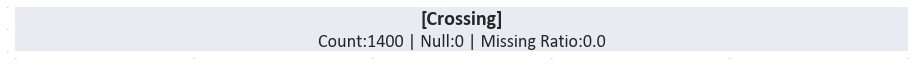

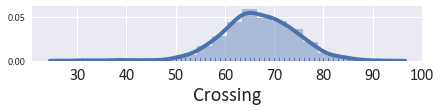

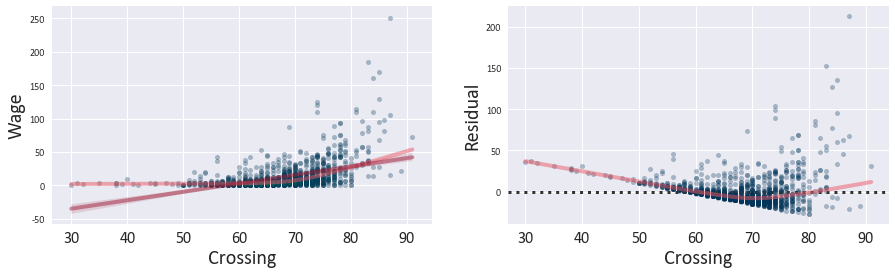

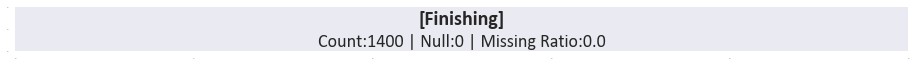

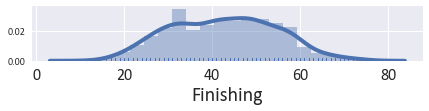

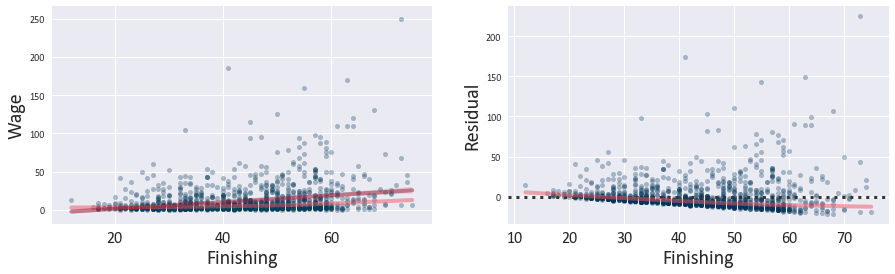

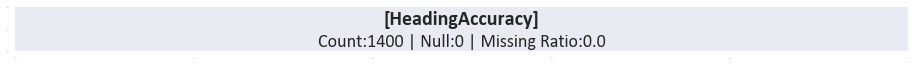

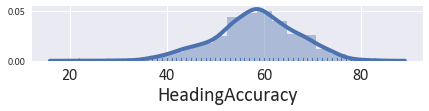

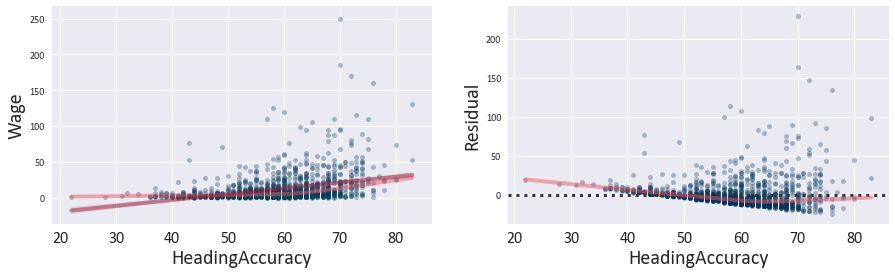

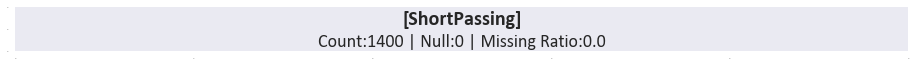

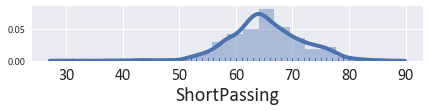

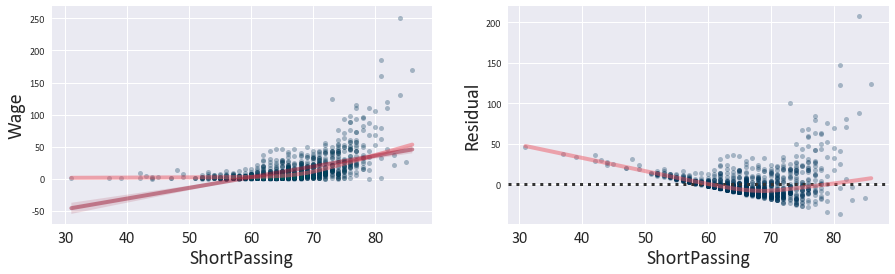

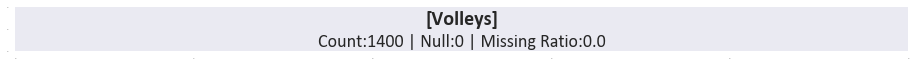

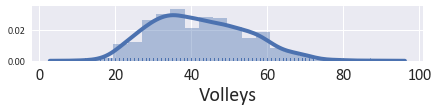

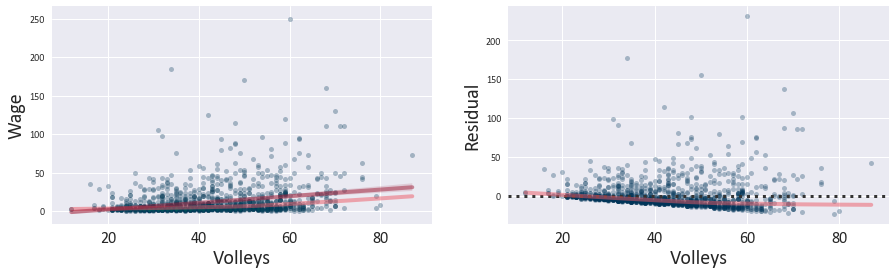

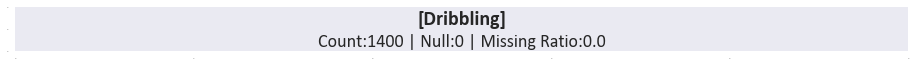

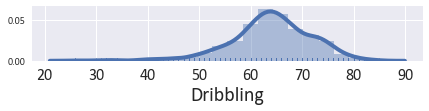

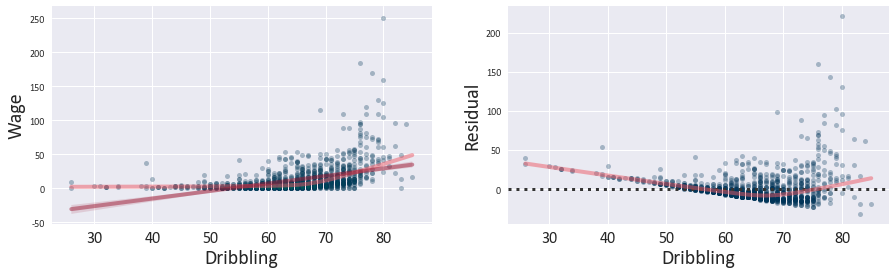

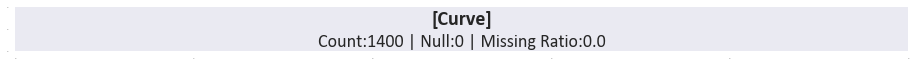

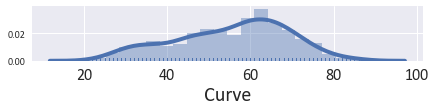

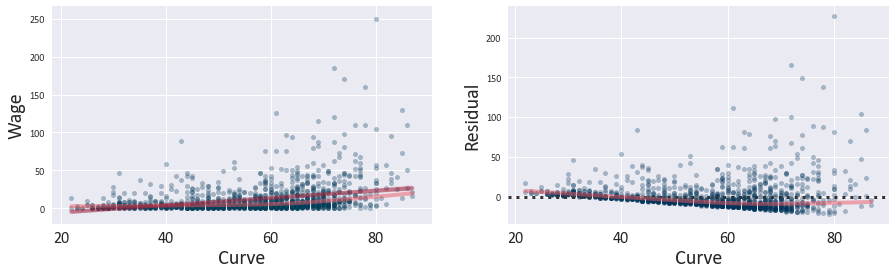

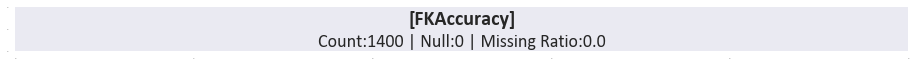

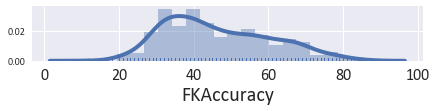

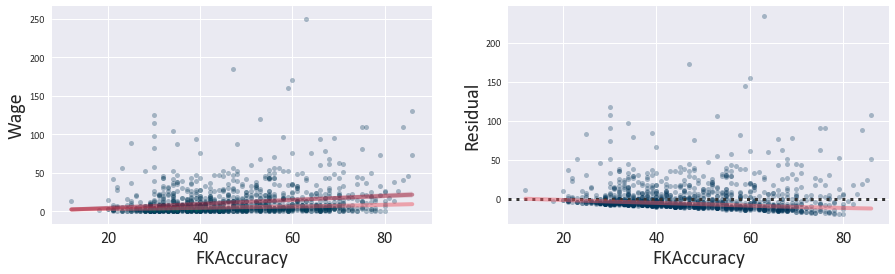

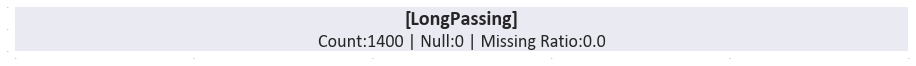

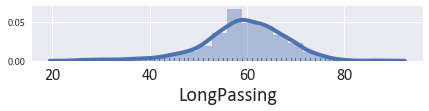

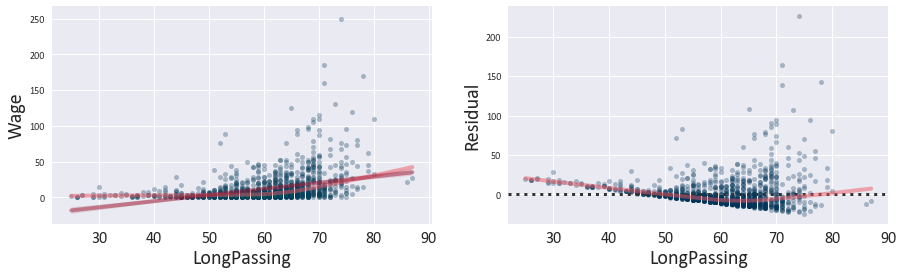

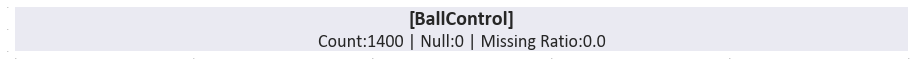

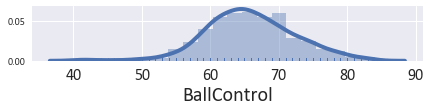

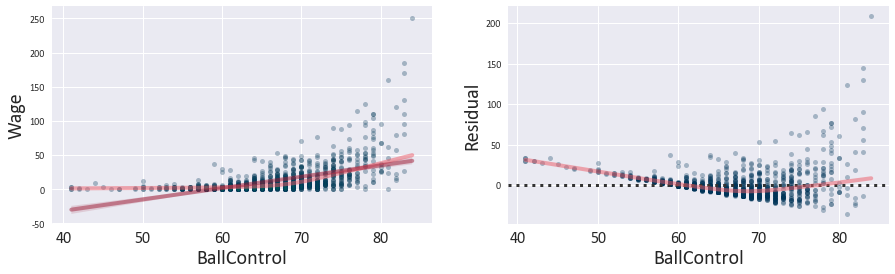

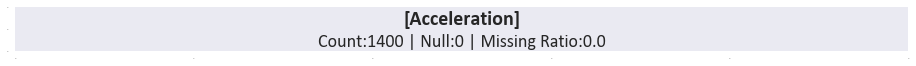

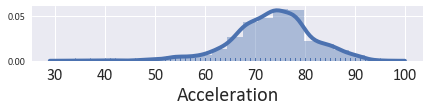

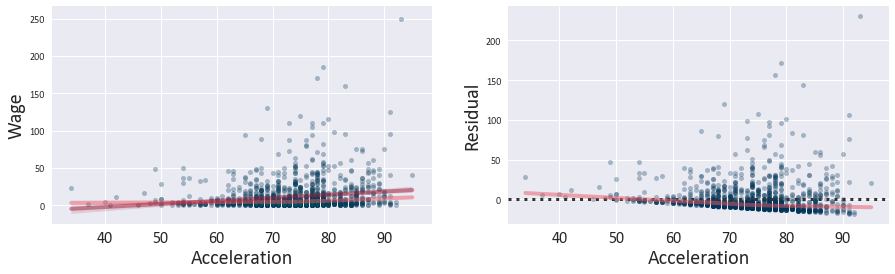

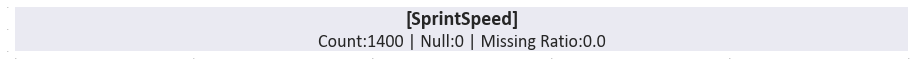

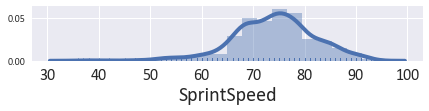

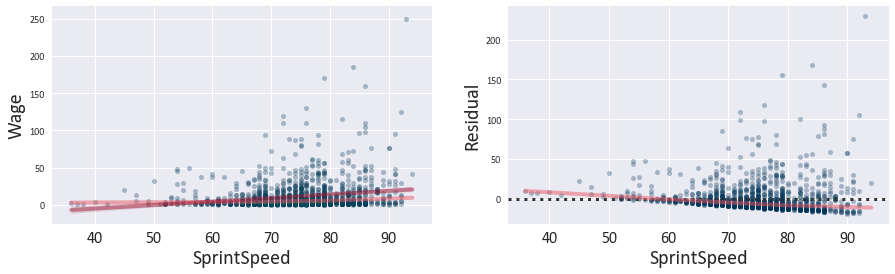

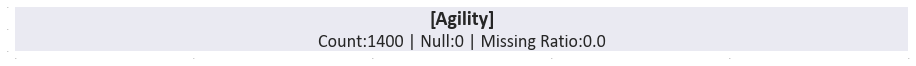

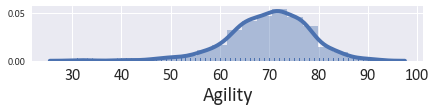

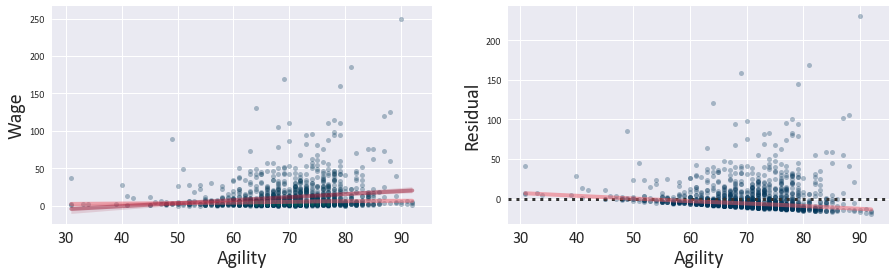

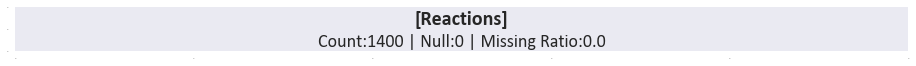

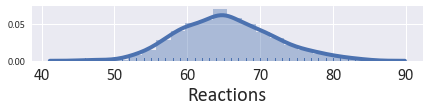

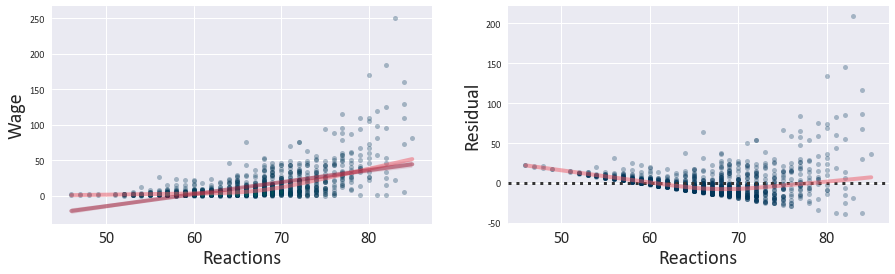

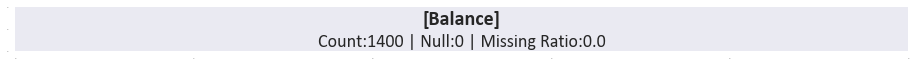

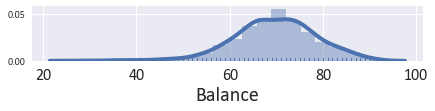

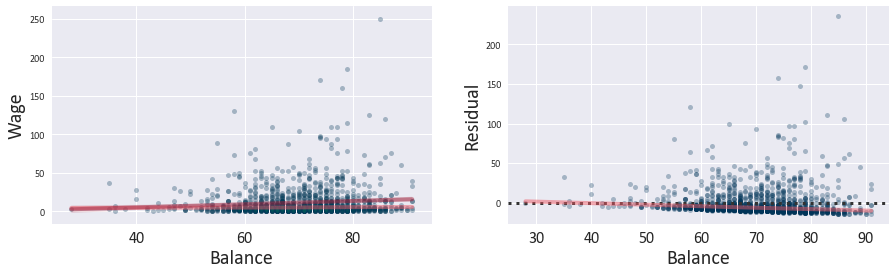

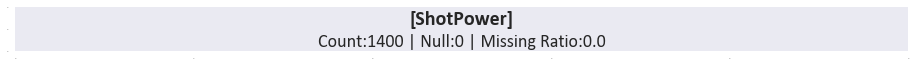

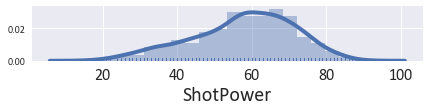

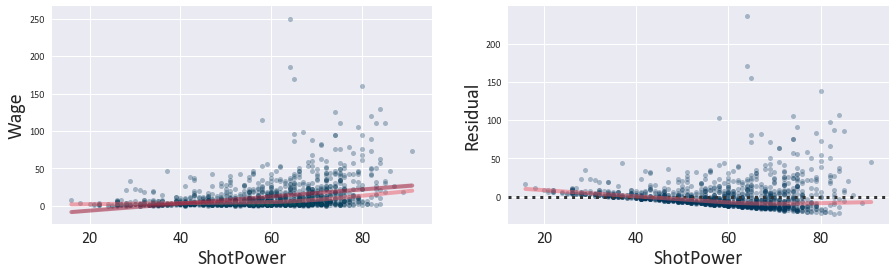

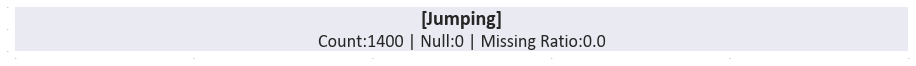

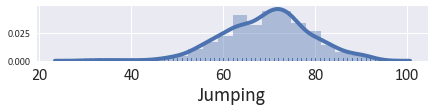

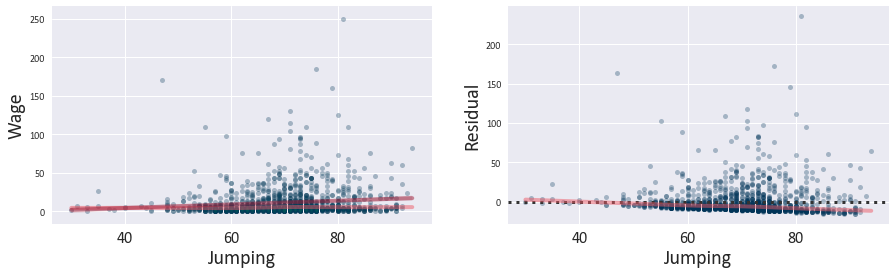

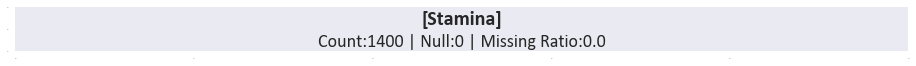

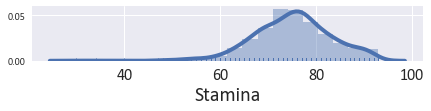

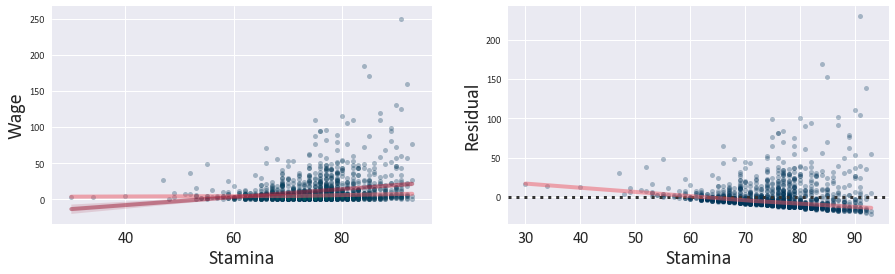

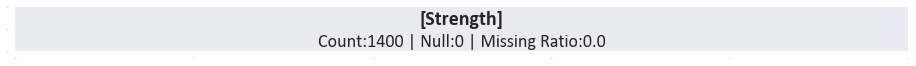

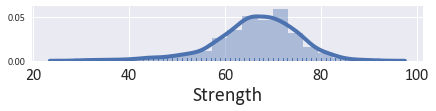

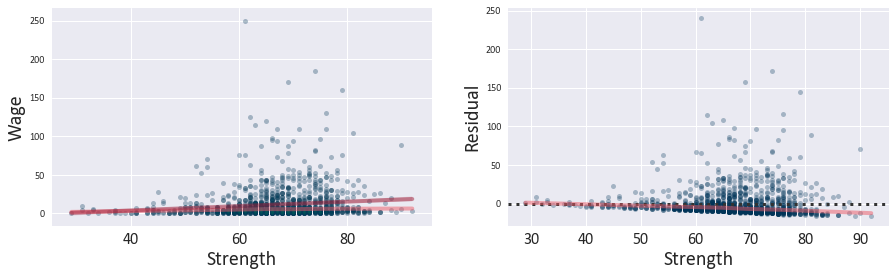

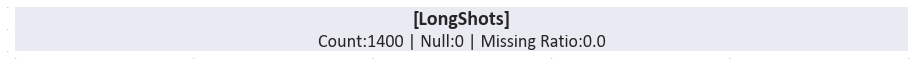

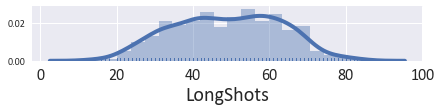

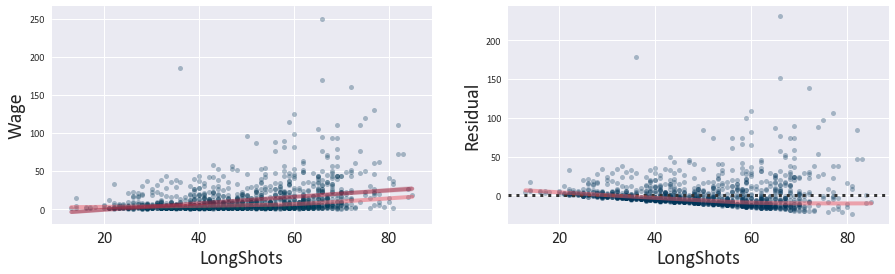

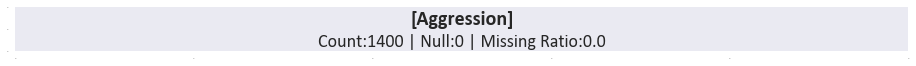

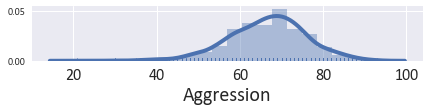

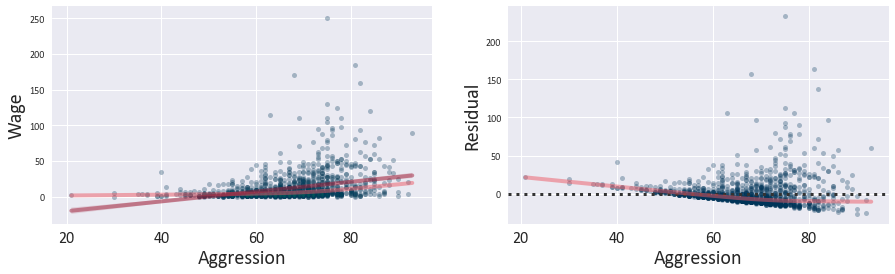

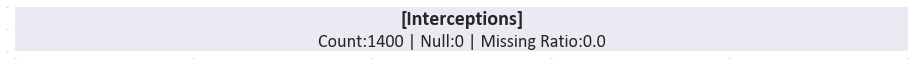

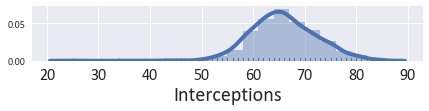

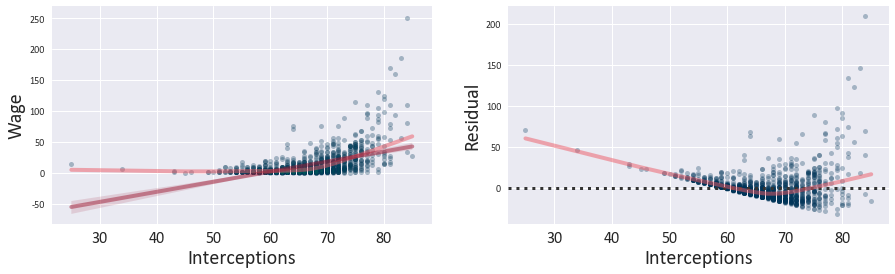

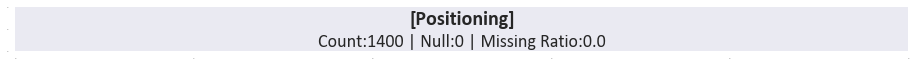

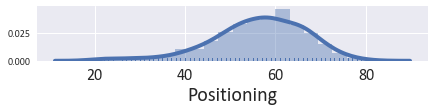

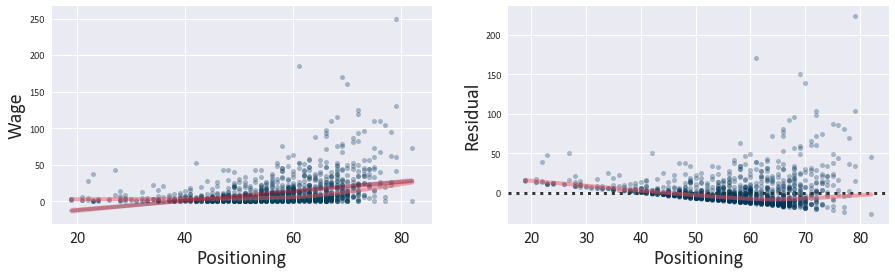

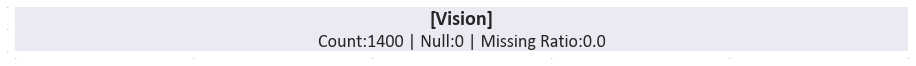

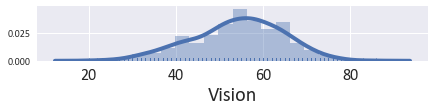

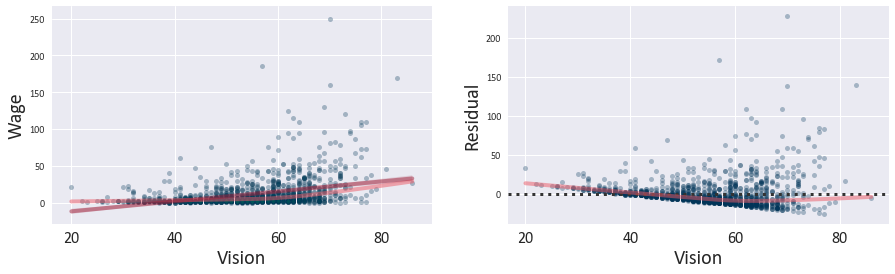

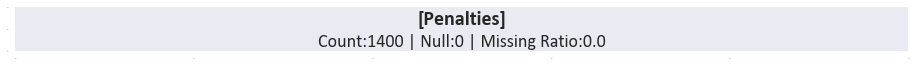

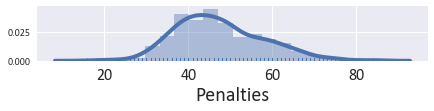

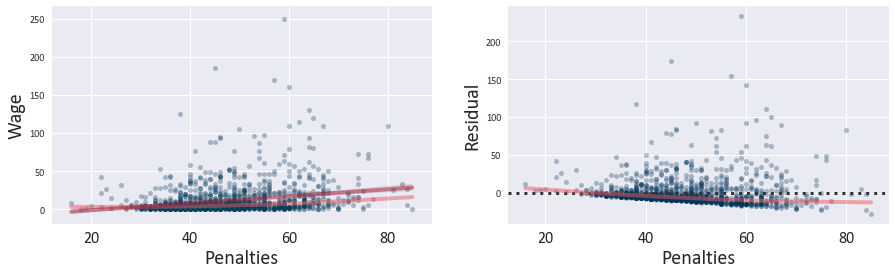

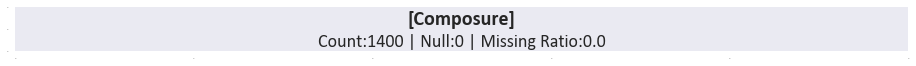

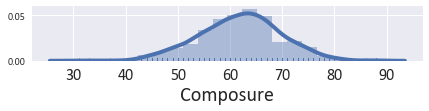

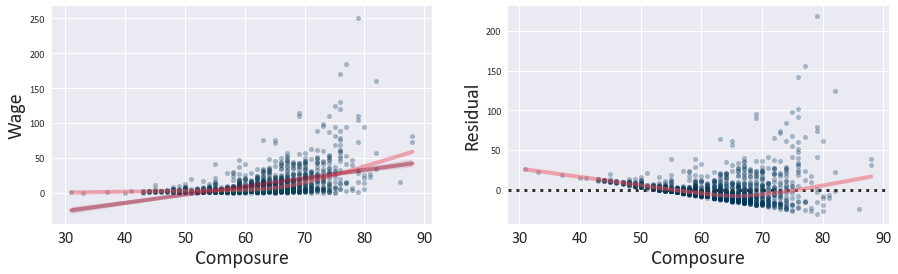

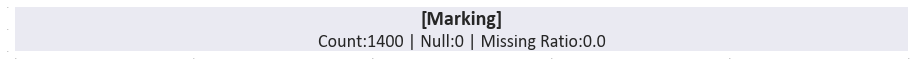

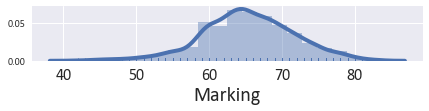

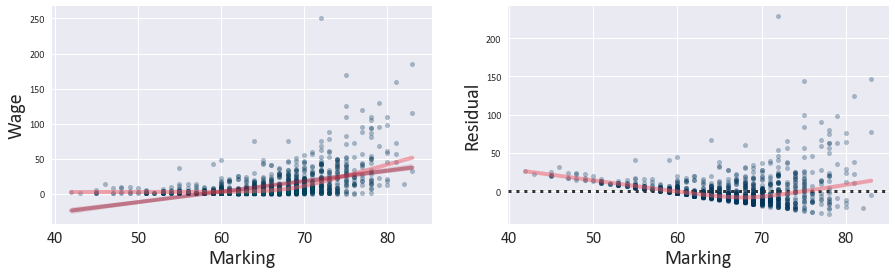

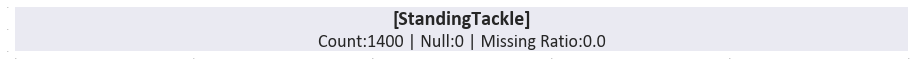

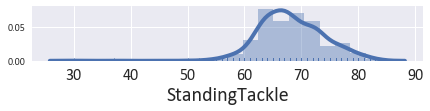

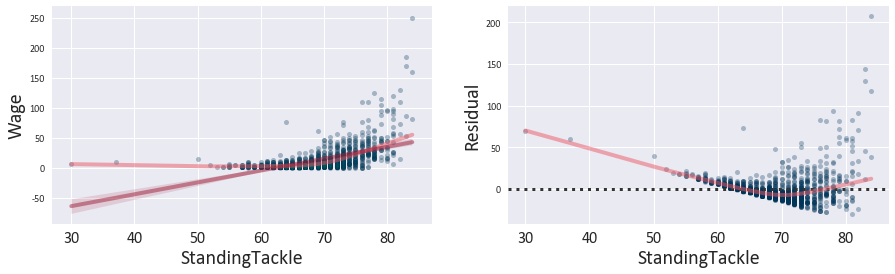

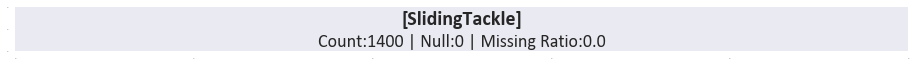

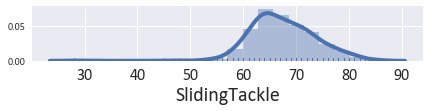

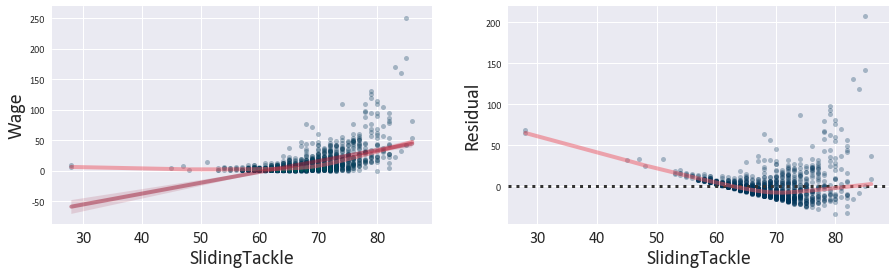

In [189]:
continuous = ['Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']

x = X_train
y = np.log1p(y_train.Wage)

for i in continuous:
    eda_continuous(x[i])
    con_N_y(x[i],y)


━━━━━━━━━━━━━━━━━━━━━━━ 【Nationality】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:700 | Null:0 | Missing Ratio:0.0

   Nationality  num  percent
9       Brazil   65     9.29
68       Spain   65     9.29
27      France   55     7.86
30     Germany   43     6.14
57    Portugal   39     5.57
..         ...  ...      ...
33      Guinea    1     0.14
37        Iran    1     0.14
35     Hungary    1     0.14
55        Peru    1     0.14
44  Luxembourg    1     0.14

[79 rows x 3 columns]

━━━━━━━━━━━━━━━━━━━━━━━ 【Club】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:688 | Null:12 | Missing Ratio:0.0171

                        Club  num  percent
196           Leicester City    5     0.73
29   Athletic Club de Bilbao    5     0.73
335            VfL Wolfsburg    5     0.73
156                Girona FC    5     0.73
256               RB Leipzig    5     0.73
..                       ...  ...      ...
163              Hannover 96    1     0.15
164   Hebei China Fortune FC    1     0.15
167           Houston Dynamo    1     0

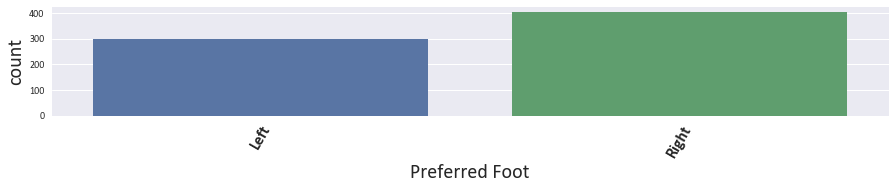

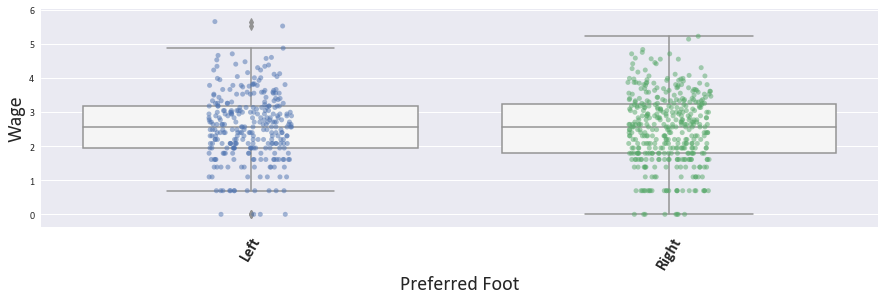


━━━━━━━━━━━━━━━━━━━━━━━ 【International Reputation】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:700 | Null:0 | Missing Ratio:0.0

   International Reputation  num  percent
0                       1.0  558    79.71
1                       2.0  122    17.43
2                       3.0   18     2.57
3                       4.0    2     0.29


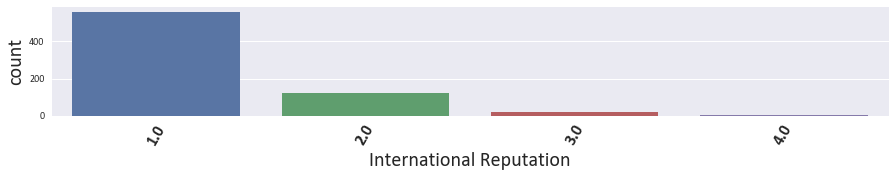

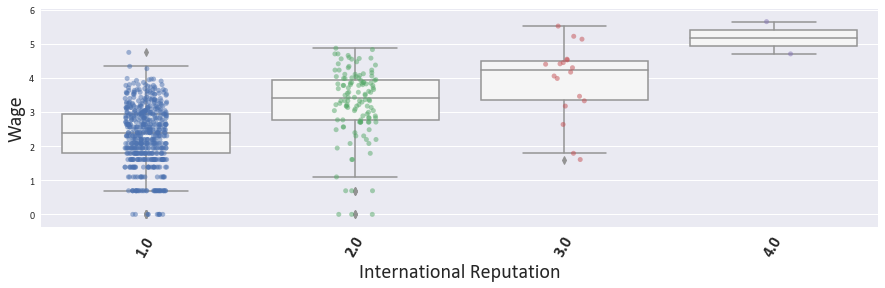


━━━━━━━━━━━━━━━━━━━━━━━ 【Weak Foot】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:700 | Null:0 | Missing Ratio:0.0

   Weak Foot  num  percent
2        3.0  447    63.86
1        2.0  151    21.57
3        4.0   92    13.14
4        5.0    8     1.14
0        1.0    2     0.29


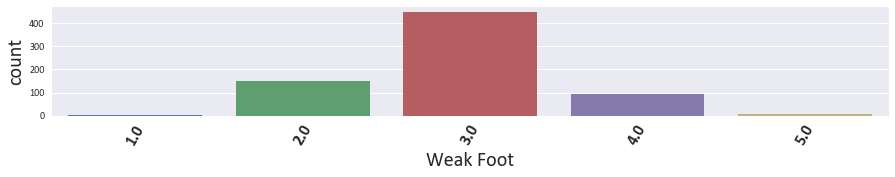

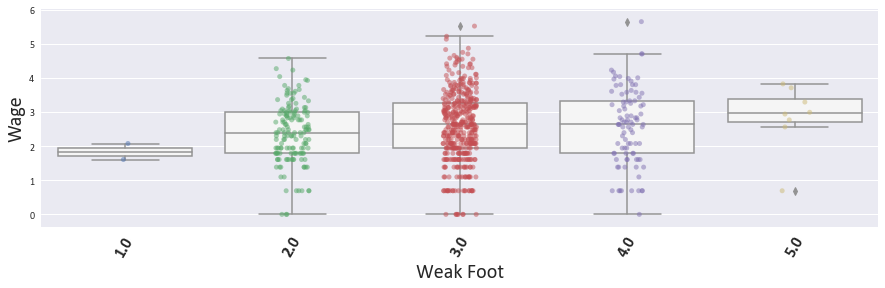


━━━━━━━━━━━━━━━━━━━━━━━ 【Skill Moves】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:700 | Null:0 | Missing Ratio:0.0

   Skill Moves  num  percent
1          3.0  515    73.57
0          2.0  157    22.43
2          4.0   27     3.86
3          5.0    1     0.14


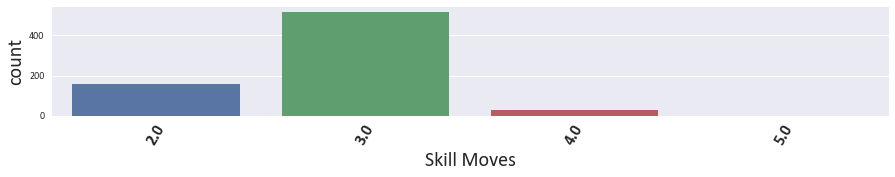

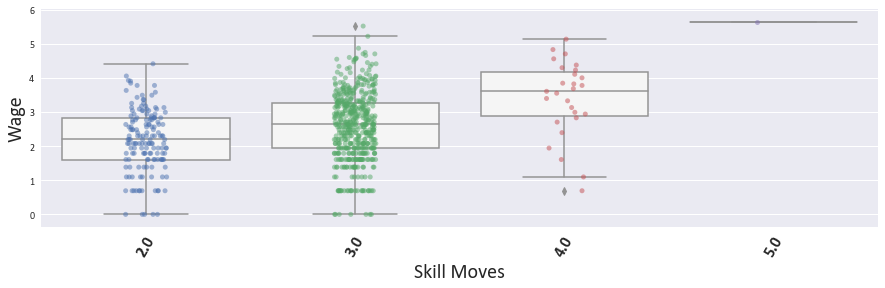


━━━━━━━━━━━━━━━━━━━━━━━ 【Work Rate】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:700 | Null:0 | Missing Ratio:0.0

        Work Rate  num  percent
2    High/ Medium  329    47.00
7  Medium/ Medium  210    30.00
0      High/ High   78    11.14
5    Medium/ High   53     7.57
1       High/ Low   16     2.29
4     Low/ Medium    6     0.86
3       Low/ High    5     0.71
6     Medium/ Low    3     0.43


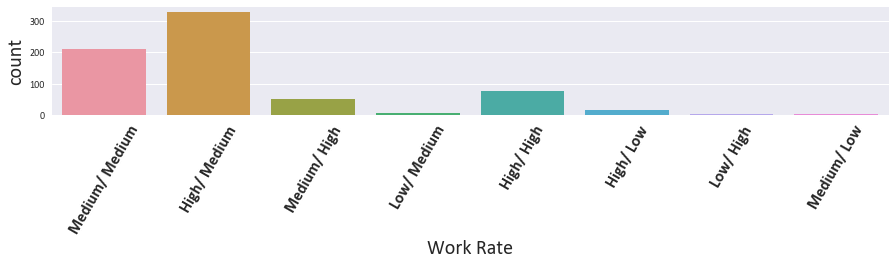

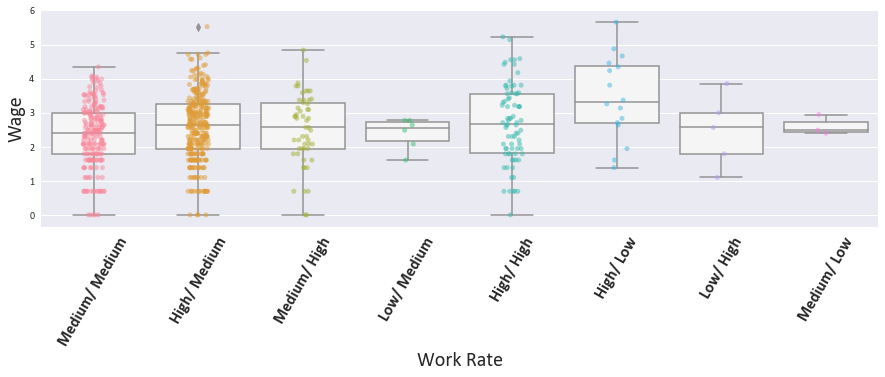


━━━━━━━━━━━━━━━━━━━━━━━ 【Body Type】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:700 | Null:0 | Missing Ratio:0.0

  Body Type  num  percent
1    Normal  412    58.86
0      Lean  242    34.57
2    Stocky   46     6.57


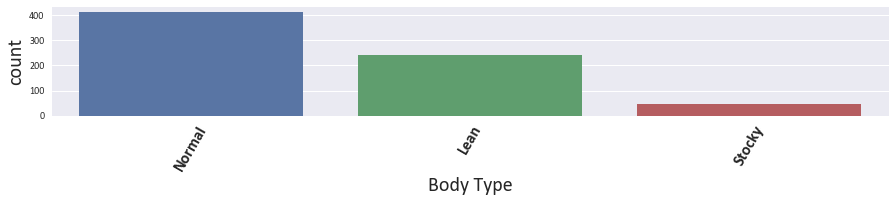

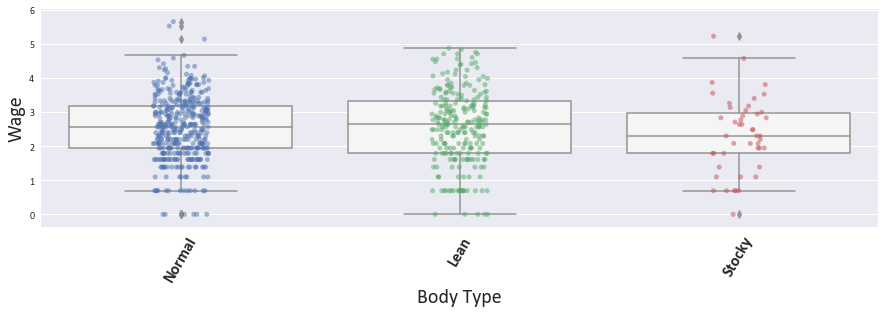


━━━━━━━━━━━━━━━━━━━━━━━ 【Real Face】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:700 | Null:0 | Missing Ratio:0.0

  Real Face  num  percent
0        No  557    79.57
1       Yes  143    20.43


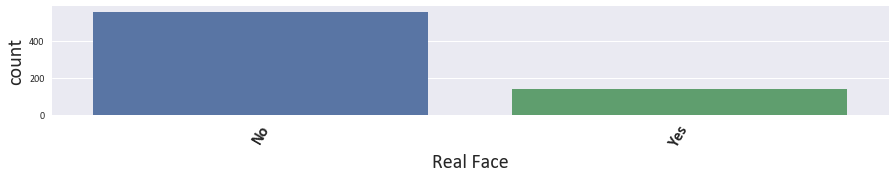

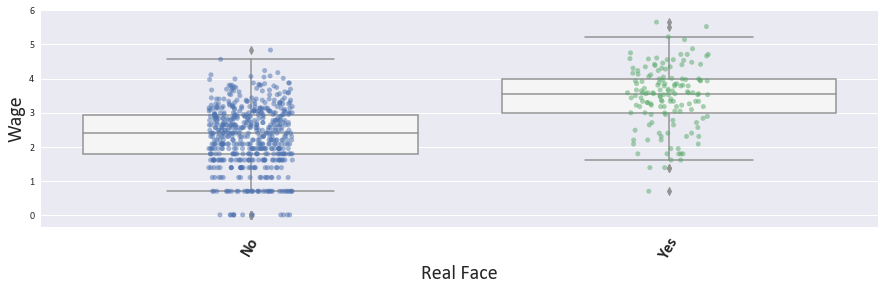


━━━━━━━━━━━━━━━━━━━━━━━ 【Position】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:700 | Null:0 | Missing Ratio:0.0

  Position  num  percent
2       RB  351    50.14
0       LB  311    44.43
3      RWB   21     3.00
1      LWB   17     2.43


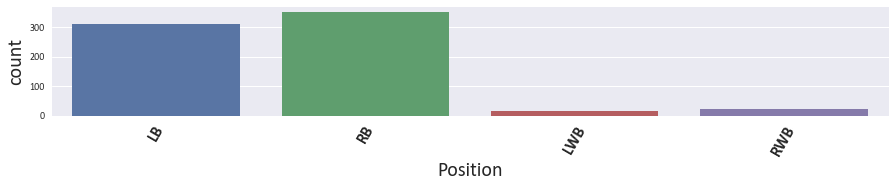

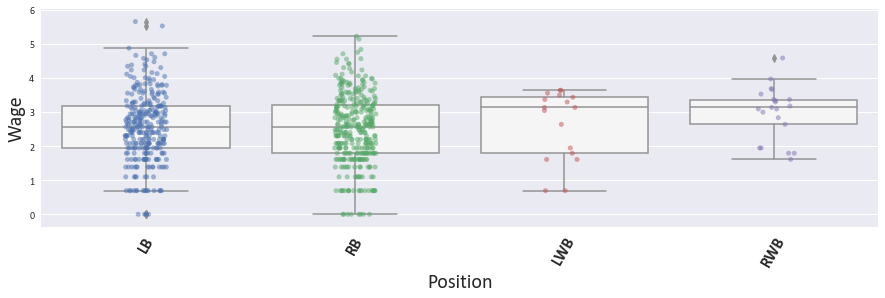


━━━━━━━━━━━━━━━━━━━━━━━ 【Jersey Number】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:700 | Null:0 | Missing Ratio:0.0

    Jersey Number  num  percent
0             2.0   99    14.14
1             3.0   62     8.86
3             5.0   32     4.57
18           20.0   30     4.29
2             4.0   28     4.00
..            ...  ...      ...
36           38.0    1     0.14
34           36.0    1     0.14
33           35.0    1     0.14
7             9.0    1     0.14
61           98.0    1     0.14

[62 rows x 3 columns]

━━━━━━━━━━━━━━━━━━━━━━━ 【Joined】 ━━━━━━━━━━━━━━━━━━━━━━━
Count:652 | Null:48 | Missing Ratio:0.0686

           Joined  num  percent
159   Jul 1, 2018   46     7.06
158   Jul 1, 2017   36     5.52
100   Jan 1, 2018   35     5.37
157   Jul 1, 2016   21     3.22
156   Jul 1, 2015   17     2.61
..            ...  ...      ...
117  Jan 24, 2015    1     0.15
118  Jan 24, 2016    1     0.15
120  Jan 25, 2017    1     0.15
122  Jan 26, 2017    1     0.15
290   Sep 9, 2015    1     0.15

[

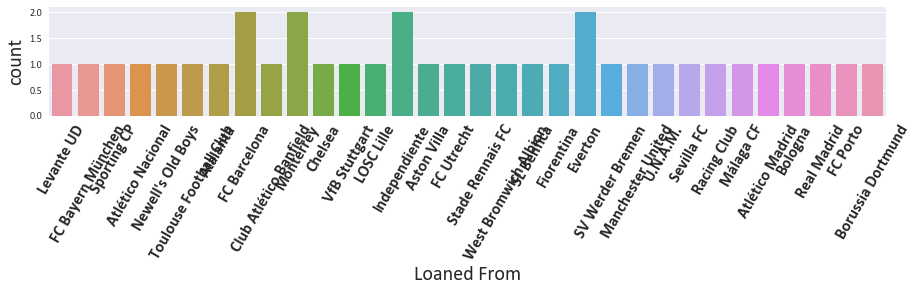

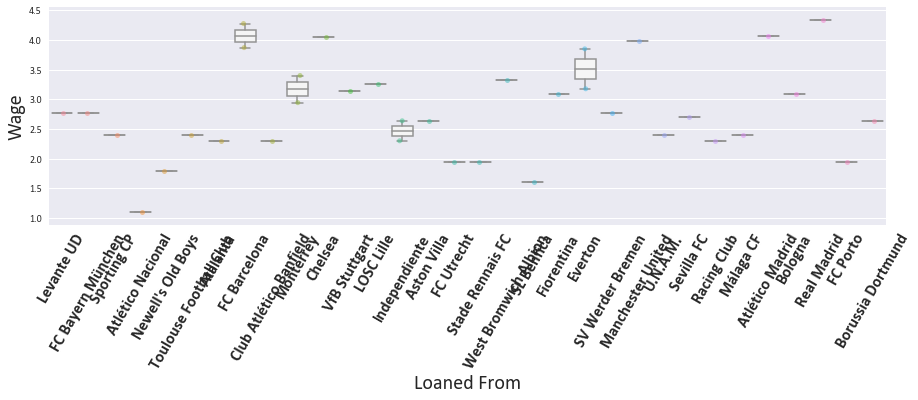

In [25]:
categorical = ['Nationality','Club', 'Preferred Foot',
               'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
               'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Joined',
               'Loaned From']

x = X_train
y = np.log1p(y_train.Wage)

for i in categorical:
    eda_categorical(x[i])
    cat_N_y(x[i],y)

# 변수간 상관관계

## Pair plot
- 자세히 보고싶은 변수 및 y를 선택해서 pair plot을 그려본다

In [ ]:
# pairplot
선형회귀/ lowess -> 국소 선형회귀

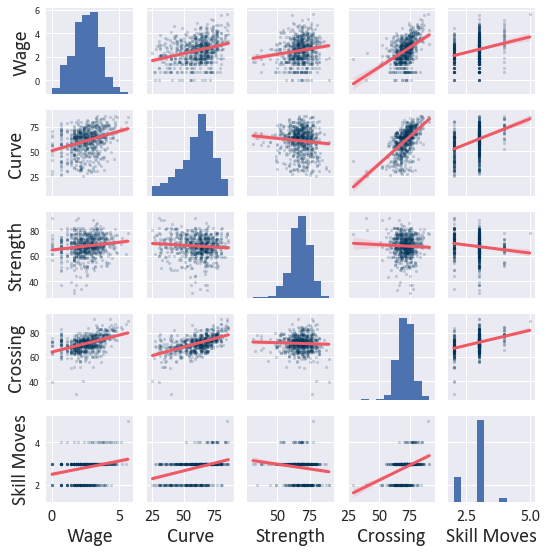

In [22]:
x = X_train.loc[:,['Curve','Strength','Crossing','Skill Moves']]
y  =np.log1p(y_train.Wage)
x = pd.concat([y,x],axis=1)

sns.pairplot(x,kind='reg',size=1.5,
             plot_kws={'line_kws':{'color':'#ED5A66', 'lw':3},
                       'scatter_kws':{"s": 10, 'alpha':0.2,'color':'#003458'}})

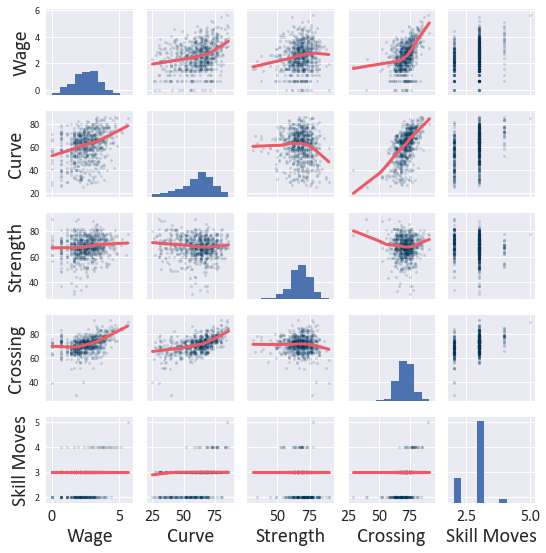

In [152]:
x = X_train.loc[:,['Curve','Strength','Crossing','Skill Moves']]
y  =np.log1p(y_train.Wage)
x = pd.concat([y,x],axis=1)

g = sns.PairGrid(x, size=1.5)
g.map_diag(plt.hist)
g.map_upper(sns.regplot, lowess=True, scatter_kws={'alpha':0.15, 'color':'#003458', 's':10}, 
                                      line_kws={'color': '#ED5A66','lw':3})
g.map_lower(sns.regplot, lowess=True, scatter_kws={'alpha':0.15, 'color':'#003458', 's':10}, 
                                     line_kws={'color': '#ED5A66','lw':3})

## Heat map

- 다양한 colormap 스타일을 적용해보자.

- 최소값, 중간값, 최대값이 시각적으로 쉽게 구분되는 스타일을 선택하자

    `viridis`,`gnuplot`,`gnuplot2`,`cool`,`hot`,`afmhot`,`Spectral`

    `RdYlBu`,`RdYlBu` 등등..

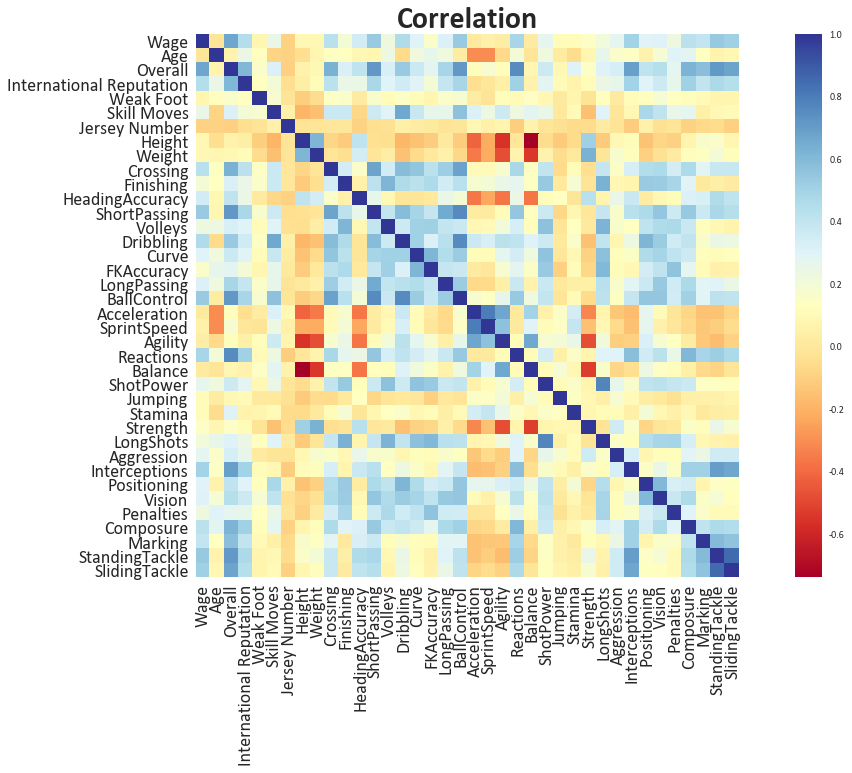

In [175]:
y=np.log1p(y_train.Wage)
df = pd.concat([y,X_train],axis=1)
x=df.corr()

plt.figure(figsize=(20,10))
sns.heatmap(x, cmap='RdYlBu' ,annot=False, square=True)
plt.title('Correlation', fontsize=30, weight='bold')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation=0)

plt.show()

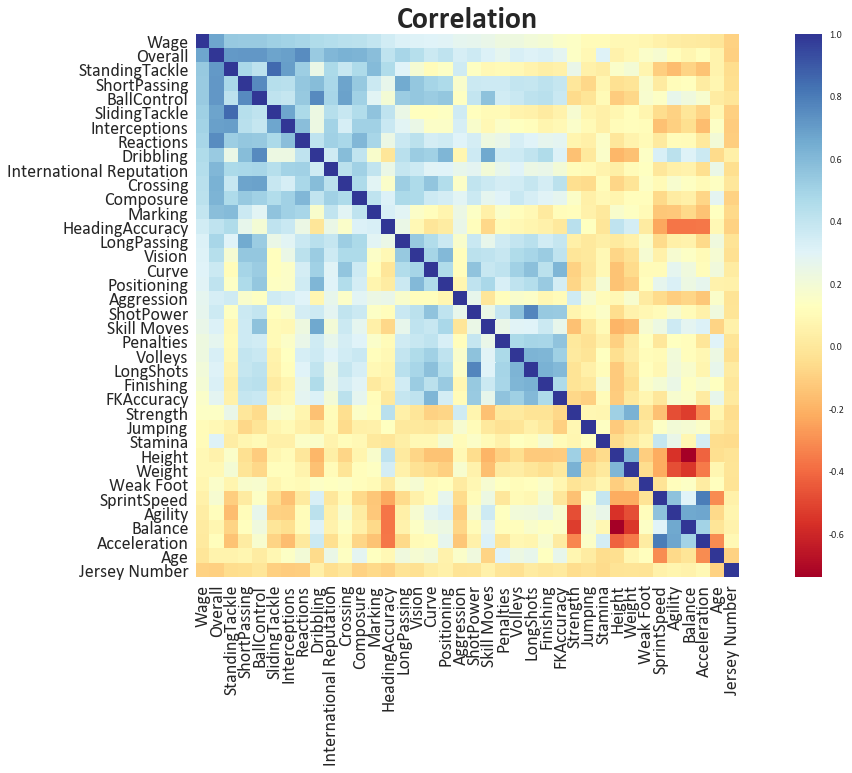

In [176]:
#높은것부터 낮은것 순으로 보기
#상위 n개만 상관관계 확인

x = df.corr()
n=100
top = x.sort_values(by='Wage', ascending=False).index[:n]
x = x.sort_values(by='Wage', ascending=False).iloc[:n,:].loc[:,top]

plt.figure(figsize=(20,10))
sns.heatmap(x, cmap='RdYlBu' ,annot=False, square=True)
plt.title('Correlation', fontsize=30, weight='bold')
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()

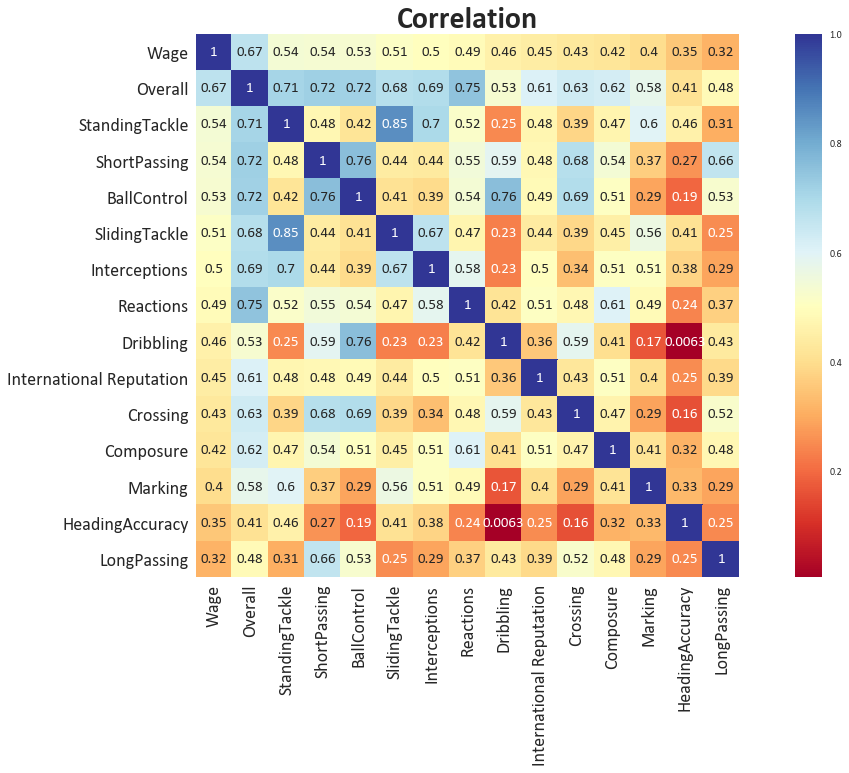

In [177]:
#높은것부터 낮은것 순으로 보기
#상위 n개만 상관관계 확인
#절대값 씌워서 보기

x = df.corr()
n=15
top = abs(x).sort_values(by='Wage', ascending=False).index[:n]
x = abs(x).sort_values(by='Wage', ascending=False).iloc[:n,:].loc[:,top]

plt.figure(figsize=(20,10))
sns.heatmap(x, cmap='RdYlBu' ,annot=True, square=True)
plt.title('Correlation', fontsize=30, weight='bold')
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()

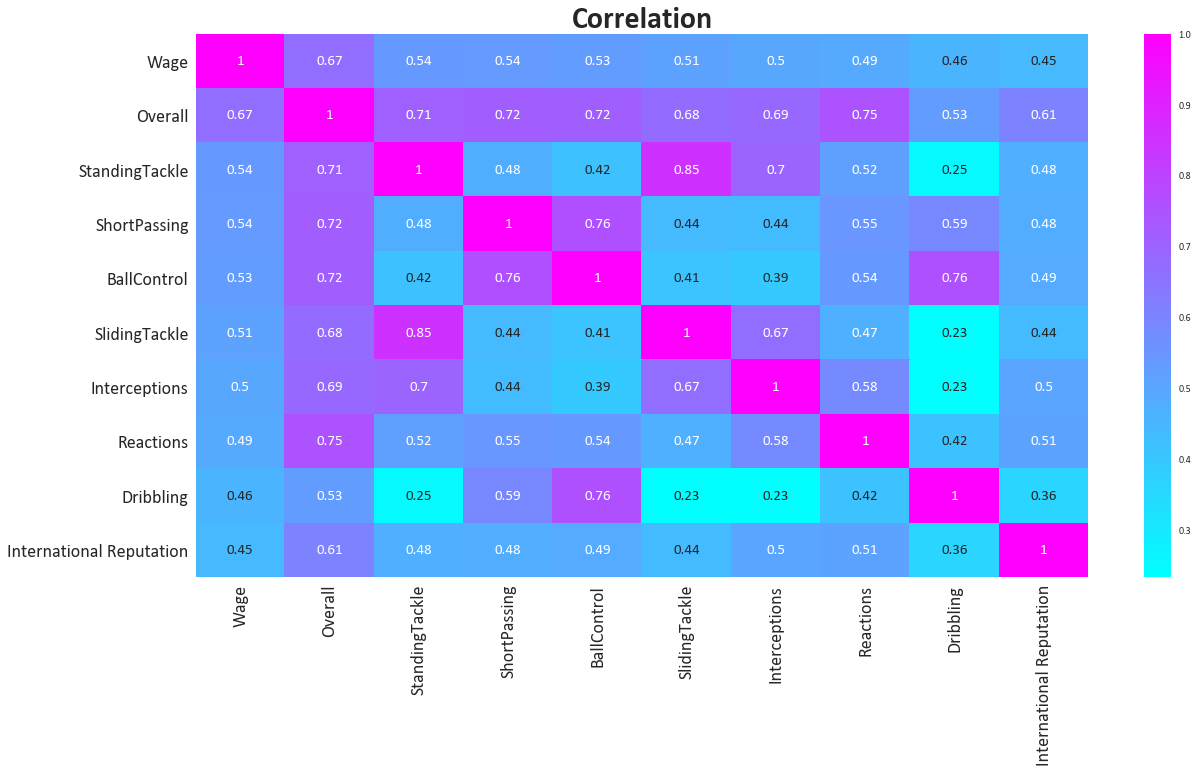

In [67]:
#상위 n개만 상관관계 확인

x = df.corr()
n=10
top = abs(x).sort_values(by='Wage', ascending=False).index[:n]
x = abs(x).sort_values(by='Wage', ascending=False).iloc[:n,:].loc[:,top]

plt.figure(figsize=(20,10))
sns.heatmap(x, cmap='cool' ,annot=True, square=False)
plt.title('Correlation', fontsize=30, weight='bold')
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()

In [179]:
# 판다스로 heatmap 그리기

pd.set_option('precision',3)  #default=6
y=np.log1p(y_train.Wage)
df = pd.concat([y,X_train],axis=1)
x=df.corr()


x.style.background_gradient(cmap='Spectral')

In [180]:
# 판다스로 heatmap 그리기
y=np.log1p(y_train.Wage)
df = pd.concat([y,X_train],axis=1)
x=df.corr()

n=10

top = abs(x).sort_values(by='Wage', ascending=False).index[:n]

x = abs(x).sort_values(by='Wage', ascending=False).iloc[:n,:].loc[:,top]

x.style.background_gradient(cmap='Spectral')